In [ ]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
X = np.load("X_features.npy")  # MFCC features
y = np.load("y_labels.npy")  # Labels

print(X.shape[1])

4000


In [ ]:
#PCA

def standardise_data(dataset):
  mean=np.mean(dataset,axis=0) #Mean
  std_dev=np.std(dataset,axis=0) #Standard Deviation
  std_data=(dataset-mean)/std_dev #Standardised Data

  return std_data

#Covariance matrix

def covariance_matrix(dataset):
  m=dataset.shape[0] #no of samples in the dataset
  cov_matrix=np.dot(dataset.T,dataset)/(m-1) #Covariance Matrix

  return cov_matrix

#Eigenvalues and Eigenvectors

def eigenvalues_eigenvectors(cov_matrix):
  eigenvalues,eigenvectors=np.linalg.eig(cov_matrix)

  return eigenvalues,eigenvectors

def sort_eigenpairs(eigenvalues,eigenvectors):
  sorted_indices=np.argsort(eigenvalues)[::-1] #Sorting in descending order
  sorted_eigenvalues=eigenvalues[sorted_indices]
  sorted_eigenvectors=eigenvectors[:,sorted_indices]

  return sorted_eigenvalues,sorted_eigenvectors

def project_dataset_to_new_plane(X, eigenvectors, top_n=1):
  W=eigenvectors[:,:top_n]

  projected_data=np.dot(X,W)

  return projected_data

<ipython-input-4-8918c80611e3>:80: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(likelihoods)) + np.log(self.priors[c])


Train Accuracy: 75.84%
Validation Accuracy: 70.90%
Test Accuracy: 68.39%


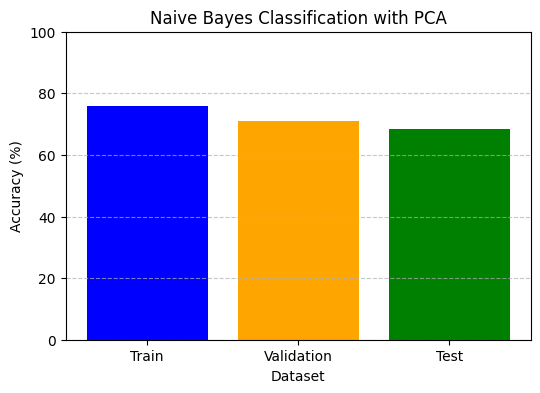

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
X = np.load("X_features.npy")  # MFCC Features
y = np.load("y_labels.npy")    # Labels

# Standardize the Data
def standardise_data(dataset):
    mean = np.mean(dataset, axis=0)
    std_dev = np.std(dataset, axis=0)
    return (dataset - mean) / std_dev

X_standardized = standardise_data(X)

# Compute Covariance Matrix
def covariance_matrix(dataset):
    m = dataset.shape[0]
    return np.dot(dataset.T, dataset) / (m - 1)

cov_matrix = covariance_matrix(X_standardized)

# Compute Eigenvalues & Eigenvectors
def eigenvalues_eigenvectors(cov_matrix):
    return np.linalg.eig(cov_matrix)

eigenvalues, eigenvectors = eigenvalues_eigenvectors(cov_matrix)

# Sort Eigenvalues & Eigenvectors
def sort_eigenpairs(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]
    return eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]

sorted_eigenvalues, sorted_eigenvectors = sort_eigenpairs(eigenvalues, eigenvectors)

# Reduce Dimension using PCA (Select Top `n` Components)
top_n = 10
def project_dataset_to_new_plane(X, eigenvectors, top_n):
    W = eigenvectors[:, :top_n]
    return np.dot(X, W)

X_pca = project_dataset_to_new_plane(X_standardized, sorted_eigenvectors, top_n)

# Train/Test/Validation Split
def train_val_test_split(X, y, test_size=0.2, val_size=0.2, seed=42):
    np.random.seed(seed)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    test_split = int(len(indices) * (1 - test_size))
    val_split = int(test_split * (1 - val_size))

    train_idx, val_idx, test_idx = indices[:val_split], indices[val_split:test_split], indices[test_split:]

    return X[train_idx], X[val_idx], X[test_idx], y[train_idx], y[val_idx], y[test_idx]

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_pca, y, test_size=0.2, val_size=0.2)

# Naive Bayes Classifier from Scratch
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {}  # P(y)
        self.means = {}   # mean(X|y)
        self.variances = {}  # var(X|y)

        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = len(X_c) / len(y)
            self.means[c] = np.mean(X_c, axis=0)
            self.variances[c] = np.var(X_c, axis=0) + 1e-9  # Add small value for numerical stability

    def gaussian_pdf(self, x, mean, var):
        return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-((x - mean) ** 2) / (2 * var))

    def predict_sample(self, x):
        posteriors = {}
        for c in self.classes:
            likelihoods = self.gaussian_pdf(x, self.means[c], self.variances[c])
            posterior = np.sum(np.log(likelihoods)) + np.log(self.priors[c])
            posteriors[c] = posterior
        return max(posteriors, key=posteriors.get)

    def predict(self, X):
        return np.array([self.predict_sample(x) for x in X])

# Train & Evaluate Naive Bayes
nb = NaiveBayes()
nb.fit(X_train, y_train)

y_train_pred = nb.predict(X_train)
y_val_pred = nb.predict(X_val)
y_test_pred = nb.predict(X_test)

# Compute Accuracy
def compute_accuracy(y_true, y_pred):
    return np.sum(y_pred == y_true) / len(y_true) * 100

train_acc = compute_accuracy(y_train, y_train_pred)
val_acc = compute_accuracy(y_val, y_val_pred)
test_acc = compute_accuracy(y_test, y_test_pred)

# Print Accuracy Scores
print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

#  Bar Plot for Accuracy
plt.figure(figsize=(6, 4))
plt.bar(["Train", "Validation", "Test"], [train_acc, val_acc, test_acc], color=["blue", "orange", "green"])
plt.xlabel("Dataset")
plt.ylabel("Accuracy (%)")
plt.title("Naive Bayes Classification with PCA")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


<ipython-input-4-8918c80611e3>:80: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(likelihoods)) + np.log(self.priors[c])


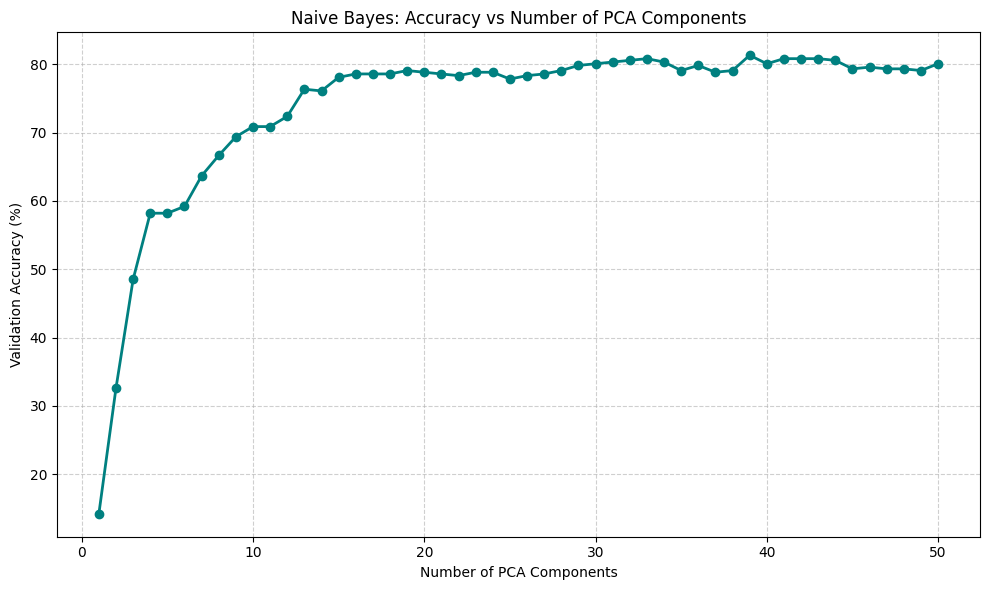

In [ ]:
# Evaluate Naive Bayes for different numbers of PCA components
accuracies = []
component_range = range(1, min(X.shape[1], 50) + 1)  # Try up to 50 or total feature count

for n in component_range:
    X_proj = project_dataset_to_new_plane(X_standardized, sorted_eigenvectors, n)
    X_train_n, X_val_n, X_test_n, y_train_n, y_val_n, y_test_n = train_val_test_split(X_proj, y)

    nb = NaiveBayes()
    nb.fit(X_train_n, y_train_n)
    y_val_pred_n = nb.predict(X_val_n)

    val_acc_n = compute_accuracy(y_val_n, y_val_pred_n)
    accuracies.append(val_acc_n)

# Plot Accuracy vs Number of PCA Components
plt.figure(figsize=(10, 6))
plt.plot(component_range, accuracies, marker='o', color='teal', linewidth=2)
plt.xlabel("Number of PCA Components")
plt.ylabel("Validation Accuracy (%)")
plt.title("Naive Bayes: Accuracy vs Number of PCA Components")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
